In [1]:
import sys
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd

%pylab inline
IPythonConsole.ipython_3d = True

import py3Dmol
import matplotlib.pyplot as plt
import subprocess

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

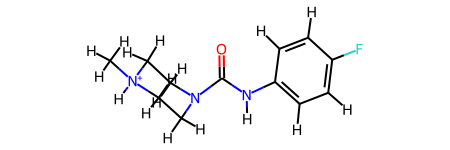

In [2]:
#Generate a mol object from a SMILES string
mol = Chem.MolFromSmiles('C[NH+]1CCN(CC1)C(=O)Nc1ccc(F)cc1') #This is the ligand in the crystal structure
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)
mol


In [4]:
# File locations
sdfFilePath = 'asinexSelectionexport.sdf'

ConfoutputFilePath = 'asinexSelectionForDocking.sdf' # Output file containing conformations for docking to SMINA

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

10

In [5]:
#Check that all molecules have a name
for i, mol in enumerate(inputMols):
    if mol is None:
        print('Warning: Failed to read molecule %s in %s' % (i, sdfFilePath))
    if not mol.GetProp('_Name'):

        print('Warning: No name for molecule %s in %s' % (i, sdfFilePath))


Conformation generation We next generate conformations, this uses paralellisation code from http://www.rdkit.org/docs/Cookbook.html contributed by Andrew Dalke. We don't use all cores on a desktop machine or it might be unresponsive. If running on a cluster you should modify this.

In [8]:
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()


Generating conformations; 100% Time: 0:00:00 |################################|


Docking to Protein After generating the conformations we can now do the docking. In this example we use smina which can be downloaded from https://sourceforge.net/projects/smina/ you will need to know where smina has been installed. The protein and ligand examples provided are taken from https://fragalysis.diamond.ac.uk/viewer/react/preview/target/MURD MURD-x0373. Docking using smina Need protein minus the ligand in pdb format, the ligand extracted from binding site in pdb format, Conformations to be docked as sdf from conformation generation above DockedFilePath = 'All_Docked.sdf.gz' is the File for the Docked structures

In [9]:
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static

--2022-10-18 19:31:46--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 104.18.11.128, 104.18.10.128
Connecting to sourceforge.net (sourceforge.net)|104.18.11.128|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABjTv8itwL_tANabDgH2_UsYfapd6uSYKc2_uzUqQfQ9Rf6SLkh8CK9WqsP7Ih8h3Ld2NbXpN6Wxav8pXAPMMl8soEwCA%3D%3D&use_mirror=cytranet&r= [following]
--2022-10-18 19:31:46--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABjTv8itwL_tANabDgH2_UsYfapd6uSYKc2_uzUqQfQ9Rf6SLkh8CK9WqsP7Ih8h3Ld2NbXpN6Wxav8pXAPMMl8soEwCA%3D%3D&use_mirror=cytranet&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cytranet.dl.source

In [10]:
!chmod u+x smina.static

In [13]:
ProteinForDocking = 'protein_minus_ligand.pdb'
LigandFromProtein = '373ligand_only.pdb'
DockedFilePath = 'All_Docked.sdf.gz'
FlexibleDockedFilePath = 'FlexDocked.sdf.gz'

In [15]:
!'./smina.static' --cpu 8 --seed 123 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' -o '{DockedFilePath}'

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 123

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1      

Rescore using a random forest model described in https://www.nature.com/articles/srep46710 Download from https://github.com/oddt/rfscorevs You will need the path to the binary Path to protein containing ligand in pdb format protein_plus_373ligand from Diamond File to store rescored results

In [16]:
!wget http://wojcikowski.pl/travis/rf-score-vs_v1.0_linux_2.7.zip
!unzip rf-score-vs_v1.0_linux_2.7.zip
!./rf-score-vs --hy



--2022-10-18 19:41:09--  http://wojcikowski.pl/travis/rf-score-vs_v1.0_linux_2.7.zip
Resolving wojcikowski.pl (wojcikowski.pl)... 128.204.218.154
Connecting to wojcikowski.pl (wojcikowski.pl)|128.204.218.154|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://wojcikowski.pl/travis/rf-score-vs_v1.0_linux_2.7.zip [following]
--2022-10-18 19:41:10--  https://wojcikowski.pl/travis/rf-score-vs_v1.0_linux_2.7.zip
Connecting to wojcikowski.pl (wojcikowski.pl)|128.204.218.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172075220 (164M) [application/zip]
Saving to: ‘rf-score-vs_v1.0_linux_2.7.zip’

rf-score-vs_v1.0_li 100%[===================>] 164.10M  2.32MB/s    in 92s     

2022-10-18 19:42:42 (1.78 MB/s) - ‘rf-score-vs_v1.0_linux_2.7.zip’ saved [172075220/172075220]

Archive:  rf-score-vs_v1.0_linux_2.7.zip
  inflating: README.md               
  inflating: rf-score-vs             
   creating: test/
  inflating: t

In [17]:
#http://wojcikowski.pl/travis/rf-score-vs_v1.0_linux_2.7.zip
TargetProtein = 'protein_plus_373ligand.pdb'
scoreResults = 'DockedRescored.csv'
!./rf-score-vs --receptor '{TargetProtein}' '{DockedFilePath}' -o csv -O '{scoreResults}' --field name --field RFScoreVS_v2

In [18]:
docked_df = PandasTools.LoadSDF(DockedFilePath,molColName='Molecule', removeHs=False)

,minimizedAffinity,ID,Molecule
0,-5.84210,ASN 02749307,
1,-5.49535,ASN 02749307,
2,-5.26867,ASN 02749307,
3,-4.94973,ASN 02749307,
4,-4.91586,ASN 02749307,
5,-4.89796,ASN 02749307,
6,-4.87040,ASN 02749307,
7,-4.86051,ASN 02749307,
8,-4.65792,ASN 02749307,
9,-5.59455,ASN 02749307,

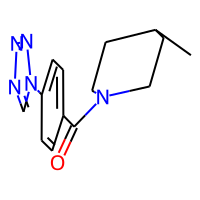
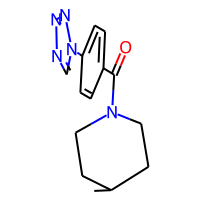
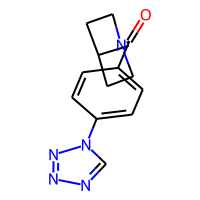
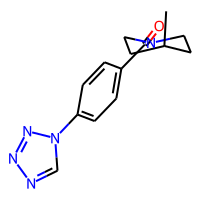
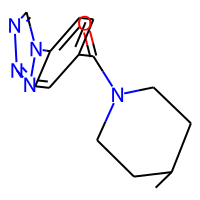
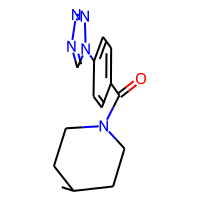
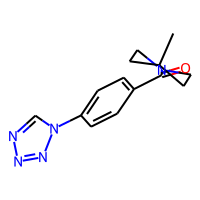
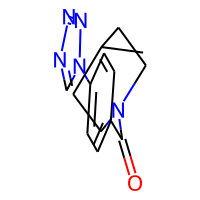
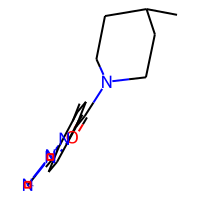
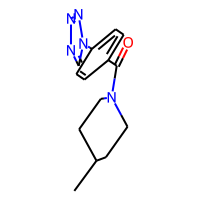

In [20]:
docked_df.head(n=10)

,minimizedAffinity,ID,Molecule,name,RFScoreVS_v2
0,-5.84210,ASN 02749307,,ASN 02749307,6.051763
1,-5.49535,ASN 02749307,,ASN 02749307,6.060875
2,-5.26867,ASN 02749307,,ASN 02749307,6.149863
3,-4.94973,ASN 02749307,,ASN 02749307,5.991118
4,-4.91586,ASN 02749307,,ASN 02749307,6.054459

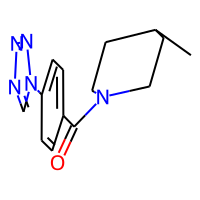
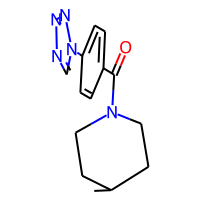
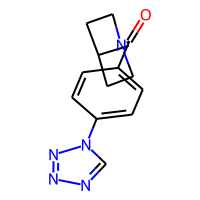
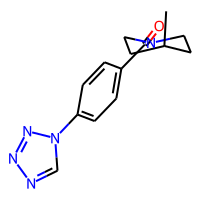
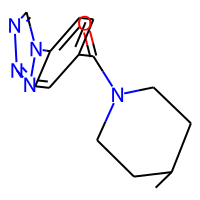

In [22]:


scores_df = pd.read_csv(scoreResults)
results_df = pd.concat([docked_df, scores_df], axis=1)
results_df.head(5)



Saving the results Now combine rescored file with docked structure file and export to "Alldata.sdf.gz" this is a big file so export compressed

In [23]:
combinedResults = 'Alldata.sdf.gz'
PandasTools.WriteSDF(results_df, combinedResults, molColName="Molecule", idName="ID", properties=list(results_df.columns))

,minimizedAffinity,ID,Molecule,name,RFScoreVS_v2
242,-7.49445,AEM 10028511,,AEM 10028511,6.138944
243,-7.49421,AEM 10028511,,AEM 10028511,6.208353
233,-7.49354,AEM 10028511,,AEM 10028511,6.145720
251,-7.45120,AEM 10028511,,AEM 10028511,6.131268
234,-7.36169,AEM 10028511,,AEM 10028511,6.160361

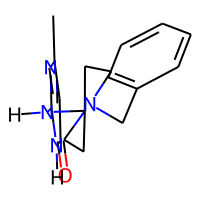
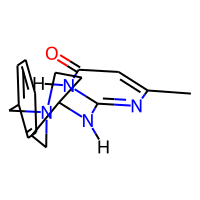
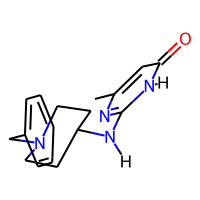
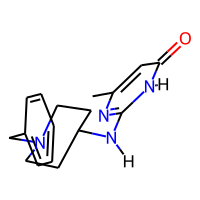
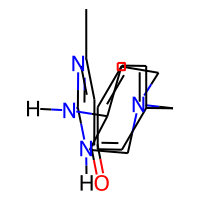

In [26]:

# results_df.sort_values(["RFScoreVS_v2"], axis=0, ascending=False, inplace=True) #or sort by scoring function
# results_df.head(5)

results_df.sort_values(["minimizedAffinity"], axis=0, ascending=False, inplace=True) #or sort by minimizedAffinity
results_df.head(5)

In [38]:


selectedPose = 'selectedpose.sdf'
selectedPoseH = 'selectedposeH.sdf'

PandasTools.WriteSDF(results_df.head(5), selectedPose, molColName="Molecule", idName="ID", properties=list(results_df.columns))

,minimizedAffinity,name,RFScoreVS_v2,ID,Molecule
0,-7.49445,AEM 10028511,6.138944,AEM 10028511,
1,-7.49421,AEM 10028511,6.208353,AEM 10028511,
2,-7.49354,AEM 10028511,6.14572,AEM 10028511,
3,-7.45120,AEM 10028511,6.131268,AEM 10028511,
4,-7.36169,AEM 10028511,6.160361,AEM 10028511,

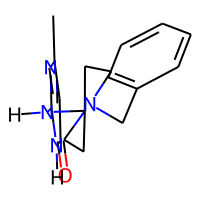
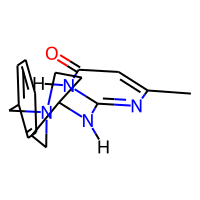
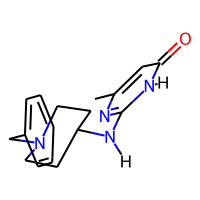
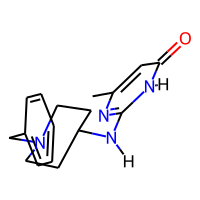
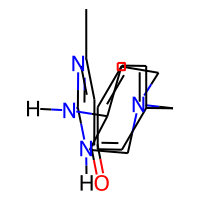

In [39]:


selecteddocked_df = PandasTools.LoadSDF(selectedPose,molColName='Molecule', removeHs=False)
selecteddocked_df



In [40]:
!obabel  -isdf 'selectedpose.sdf'  -osdf   -h  -O 'selectedposeH.sdf'

5 molecules converted


In [41]:

def DrawDocking(protein,ligand):
     complex_pl = Chem.MolToPDBBlock(protein)
     docked_pdb = Chem.MolToPDBBlock(ligand)
     viewer = py3Dmol.view(width=800,height=800)
     viewer.addModel(complex_pl,'pdb')
     viewer.addModel(docked_pdb)
     prot = {'resn': ["DMS", "UNL", "SO4", "LIG", "HOH", "Cl"], 'invert': 1}  #define prot as all except list
     viewer.setStyle(prot,{'cartoon': {'colorscheme':'ssPyMol'}}) # Colour by secondary structure
     Lig_373 = {'resn' : 'LIG'} #original ligand in pdb file
     MyLig = {'resn':'UNL'} #ligand to be added from docking
     viewer.addSurface(py3Dmol.VDW,{'opacity':0.7, 'color': 'white'}, prot)
     viewer.setStyle({'resi': '132'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '147'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '311'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle(Lig_373,{'stick':{'colorscheme': 'whiteCarbon','radius':.1}}) 
     viewer.setStyle(MyLig,{'stick':{'colorscheme' : 'greenCarbon'}})
     viewer.zoomTo(MyLig)
     return viewer  



In [43]:
mols = [m for m in Chem.SDMolSupplier(selectedPoseH)]
receptor = Chem.MolFromPDBFile(TargetProtein)
DrawDocking(receptor,mols[1])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol